1. Python packages

In [1]:
from data.data_handler import DataHandler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from math import sqrt
import torch
import torch.nn as nn
import time

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path+"//Users/jiayuelin/Code/Stock-Market-Prediction/data") # Adjust this path to your own

2. Load data

In [2]:
# Get the dataset
dh = DataHandler()
df = dh.get_stock_dataset(stock_ticket="PFE")
df = df.sort_values(by=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,1972-06-01,0.000000,0.815346,0.802993,0.815346,0.174965,2458771,-1
1,1972-06-02,0.815346,0.817817,0.802993,0.805463,0.172844,1613885,-1
2,1972-06-05,0.805463,0.807934,0.798051,0.802993,0.172314,2585251,-1
3,1972-06-06,0.802993,0.825229,0.800522,0.820288,0.176026,2347469,-1
4,1972-06-07,0.820288,0.820288,0.807934,0.820288,0.176026,1032077,-1
...,...,...,...,...,...,...,...,...
12833,2023-04-24,40.189999,40.200001,39.709999,39.910000,39.910000,17633700,-1
12834,2023-04-25,39.750000,39.919998,39.279999,39.330002,39.330002,24492400,-1
12835,2023-04-26,39.160000,39.189999,38.400002,38.630001,38.630001,22401400,1
12836,2023-04-27,38.619999,38.830002,38.310001,38.740002,38.740002,22434000,1


3. Normalize data

In [3]:
# Create the target column
update_df = df[['Close']]
update_df.head()

,Close
0,0.815346
1,0.805463
2,0.802993
3,0.820288
4,0.820288


In [4]:
# Normalize the data
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

scaler = MinMaxScaler(df[['Close']])
close_price = scaler
type(close_price)

# Implement the MinMaxScaler class
class MinMaxScaler:
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
    
    # Compute the minimum and maximum to be used for later scaling
    def fit(self, X):
        self.min_ = np.min(X, axis=0)
        self.max_ = np.max(X, axis=0)
        return self
    
    # Scale features of X according to feature_range
    def transform(self, X):
        X_std = (X - self.min_) / (self.max_ - self.min_)
        X_scaled = X_std * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
        return X_scaled

    # Fit to data, then transform it
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    # Scale back the data to the original representation
    def inverse_transform(self, X):
        X_std = (X - self.feature_range[0]) / (self.feature_range[1] - self.feature_range[0])
        X_scaled = X_std * (self.max_ - self.min_) + self.min_
        return X_scaled

scaler = MinMaxScaler()
update_df['Close'] = scaler.fit_transform(update_df['Close'].values.reshape(-1,1))
print(update_df['Close'].agg(['min','max']))
update_df.index = df['Date']
update_df


min    0.0
max    1.0
Name: Close, dtype: float64


/tmp/ipykernel_130795/354082042.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_df['Close'] = scaler.fit_transform(update_df['Close'].values.reshape(-1,1))


,Close
Date,
1972-06-01,0.006378
1972-06-02,0.006215
1972-06-05,0.006175
1972-06-06,0.006459
1972-06-07,0.006459
...,...
2023-04-24,0.649143
2023-04-25,0.639607
2023-04-26,0.628099


4. Split data

In [5]:
# function to create train, test data given stock data and sequence length
def split_data(stock, lookback):
    raw_data = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(raw_data) - lookback): 
        data.append(raw_data[index: index + lookback])
    
    # Split the data into a training and test set
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [6]:
look_back = 7 # choose sequence length
X_train, y_train, X_test, y_test = split_data(update_df, look_back)

print('x_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (10265, 6, 1)
y_train.shape =  (10265, 1)
x_test.shape =  (2566, 6, 1)
y_test.shape =  (2566, 1)


In [7]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

5. Build model

In [8]:
# Fine tune the model
input_size = 1
hidden_size = 32
num_layers = 3
output_size = 1
num_epochs = 1000

In [9]:
# Implement the LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        
        # Set the hidden dimension
        self.hidden_size = hidden_size

        # Define the number of hidden layers
        self.num_layers = num_layers

        # Define LSTM layer with batch_first=True 
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the readout layer
        self.fc_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize the hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Initialize the cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Detach hidden state to prevent exploding/vanishing gradients
        output, (hn, cn) = self.lstm_layer(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step 
        output = self.fc_layer(output[:, -1, :]) 

        return output

In [10]:
# Define the model
model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
# Define the loss function and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
# Train model
hist = np.zeros(num_epochs)    
start_time = time.time()
lstm = []

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.07998637855052948
Epoch  1 MSE:  0.044361963868141174
Epoch  2 MSE:  0.06703656911849976
Epoch  3 MSE:  0.04828120395541191
Epoch  4 MSE:  0.043030817061662674
Epoch  5 MSE:  0.04569721594452858
Epoch  6 MSE:  0.0481400229036808
Epoch  7 MSE:  0.047912150621414185
Epoch  8 MSE:  0.04553312808275223
Epoch  9 MSE:  0.04211500287055969
Epoch  10 MSE:  0.03853566199541092
Epoch  11 MSE:  0.03532218188047409
Epoch  12 MSE:  0.03249884396791458
Epoch  13 MSE:  0.028365852311253548
Epoch  14 MSE:  0.01987883821129799
Epoch  15 MSE:  0.007800364401191473
Epoch  16 MSE:  0.000579683342948556
Epoch  17 MSE:  0.0061550564132630825
Epoch  18 MSE:  0.012944460846483707
Epoch  19 MSE:  0.01177523098886013
Epoch  20 MSE:  0.006526659242808819
Epoch  21 MSE:  0.0024327842984348536
Epoch  22 MSE:  0.0012005683965981007
Epoch  23 MSE:  0.001989401411265135
Epoch  24 MSE:  0.0034596361219882965
Epoch  25 MSE:  0.004664127249270678
Epoch  26 MSE:  0.005129432305693626
Epoch  27 MSE:  0.00

Epoch  214 MSE:  0.00010199711687164381
Epoch  215 MSE:  8.996533142635599e-05
Epoch  216 MSE:  8.395920303883031e-05
Epoch  217 MSE:  9.743931877892464e-05
Epoch  218 MSE:  8.76747362781316e-05
Epoch  219 MSE:  8.32908262964338e-05
Epoch  220 MSE:  9.359546675113961e-05
Epoch  221 MSE:  8.613600220996886e-05
Epoch  222 MSE:  8.253053238149732e-05
Epoch  223 MSE:  9.046430204762146e-05
Epoch  224 MSE:  8.50501237437129e-05
Epoch  225 MSE:  8.18379849079065e-05
Epoch  226 MSE:  8.798982889857143e-05
Epoch  227 MSE:  8.430540037807077e-05
Epoch  228 MSE:  8.126773900585249e-05
Epoch  229 MSE:  8.601501031080261e-05
Epoch  230 MSE:  8.376696496270597e-05
Epoch  231 MSE:  8.082106796791777e-05
Epoch  232 MSE:  8.438961958745494e-05
Epoch  233 MSE:  8.3336686657276e-05
Epoch  234 MSE:  8.050837641349062e-05
Epoch  235 MSE:  8.301125490106642e-05
Epoch  236 MSE:  8.294272993225604e-05
Epoch  237 MSE:  8.036257349886e-05
Epoch  238 MSE:  8.184395119315013e-05
Epoch  239 MSE:  8.24916351120919

Epoch  426 MSE:  8.354692545253783e-05
Epoch  427 MSE:  7.522236410295591e-05
Epoch  428 MSE:  7.668168836971745e-05
Epoch  429 MSE:  7.9099896538537e-05
Epoch  430 MSE:  7.229228504002094e-05
Epoch  431 MSE:  7.849183748476207e-05
Epoch  432 MSE:  7.320770237129182e-05
Epoch  433 MSE:  7.469236879842356e-05
Epoch  434 MSE:  7.574332266813144e-05
Epoch  435 MSE:  7.196445221779868e-05
Epoch  436 MSE:  7.575358176836744e-05
Epoch  437 MSE:  7.24747878848575e-05
Epoch  438 MSE:  7.323561294469982e-05
Epoch  439 MSE:  7.396587170660496e-05
Epoch  440 MSE:  7.154036575229838e-05
Epoch  441 MSE:  7.372179243247956e-05
Epoch  442 MSE:  7.193125929916278e-05
Epoch  443 MSE:  7.21902324585244e-05
Epoch  444 MSE:  7.280560384970158e-05
Epoch  445 MSE:  7.126672426238656e-05
Epoch  446 MSE:  7.254289812408388e-05
Epoch  447 MSE:  7.161174289649352e-05
Epoch  448 MSE:  7.149342854972929e-05
Epoch  449 MSE:  7.20586467650719e-05
Epoch  450 MSE:  7.102770177880302e-05
Epoch  451 MSE:  7.16707290848

Epoch  638 MSE:  6.006387775414623e-05
Epoch  639 MSE:  5.998981214361265e-05
Epoch  640 MSE:  5.991553553030826e-05
Epoch  641 MSE:  5.9841015172423795e-05
Epoch  642 MSE:  5.9766287449747324e-05
Epoch  643 MSE:  5.969131234451197e-05
Epoch  644 MSE:  5.9616140788421035e-05
Epoch  645 MSE:  5.9540725487750024e-05
Epoch  646 MSE:  5.946508827037178e-05
Epoch  647 MSE:  5.9389214584371075e-05
Epoch  648 MSE:  5.931314080953598e-05
Epoch  649 MSE:  5.9236819652142e-05
Epoch  650 MSE:  5.916026566410437e-05
Epoch  651 MSE:  5.908350431127474e-05
Epoch  652 MSE:  5.9006524679716676e-05
Epoch  653 MSE:  5.892930494155735e-05
Epoch  654 MSE:  5.885187420062721e-05
Epoch  655 MSE:  5.8774210629053414e-05
Epoch  656 MSE:  5.869632150279358e-05
Epoch  657 MSE:  5.8618221373762935e-05
Epoch  658 MSE:  5.8539902966003865e-05
Epoch  659 MSE:  5.846135172760114e-05
Epoch  660 MSE:  5.8382589486427605e-05
Epoch  661 MSE:  5.8303608966525644e-05
Epoch  662 MSE:  5.8224413805874065e-05
Epoch  663 MSE:

Epoch  848 MSE:  5.682922346750274e-05
Epoch  849 MSE:  5.6789493100950494e-05
Epoch  850 MSE:  5.674886051565409e-05
Epoch  851 MSE:  5.670896280207671e-05
Epoch  852 MSE:  5.6668341130716726e-05
Epoch  853 MSE:  5.662831972585991e-05
Epoch  854 MSE:  5.658772715833038e-05
Epoch  855 MSE:  5.6547567510278895e-05
Epoch  856 MSE:  5.65069931326434e-05
Epoch  857 MSE:  5.6466724345227703e-05
Epoch  858 MSE:  5.642613541567698e-05
Epoch  859 MSE:  5.638574293698184e-05
Epoch  860 MSE:  5.634513945551589e-05
Epoch  861 MSE:  5.630467785522342e-05
Epoch  862 MSE:  5.6264027080032974e-05
Epoch  863 MSE:  5.6223459978355095e-05
Epoch  864 MSE:  5.6182791013270617e-05
Epoch  865 MSE:  5.614214751403779e-05
Epoch  866 MSE:  5.610143125522882e-05
Epoch  867 MSE:  5.606070772046223e-05
Epoch  868 MSE:  5.6019958719844e-05
Epoch  869 MSE:  5.597916242550127e-05
Epoch  870 MSE:  5.5938340665306896e-05
Epoch  871 MSE:  5.589749707723968e-05
Epoch  872 MSE:  5.5856606195447966e-05
Epoch  873 MSE:  5.

In [12]:
# Calculate mean squared error
def mean_squared_error(y_true, y_pred):
    """
    Calculates the mean squared error between the true and predicted values.
    
    Args:
        y_true (ndarray): Array of true values.
        y_pred (ndarray): Array of predicted values.
    
    Returns:
        float: Mean squared error.
    """
    mse = np.mean(np.square(y_true - y_pred))
    return mse

In [13]:
# Inverse transform the data
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
train = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

In [14]:
# make predictions
y_test_pred = model(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.43 RMSE
Test Score: 0.74 RMSE


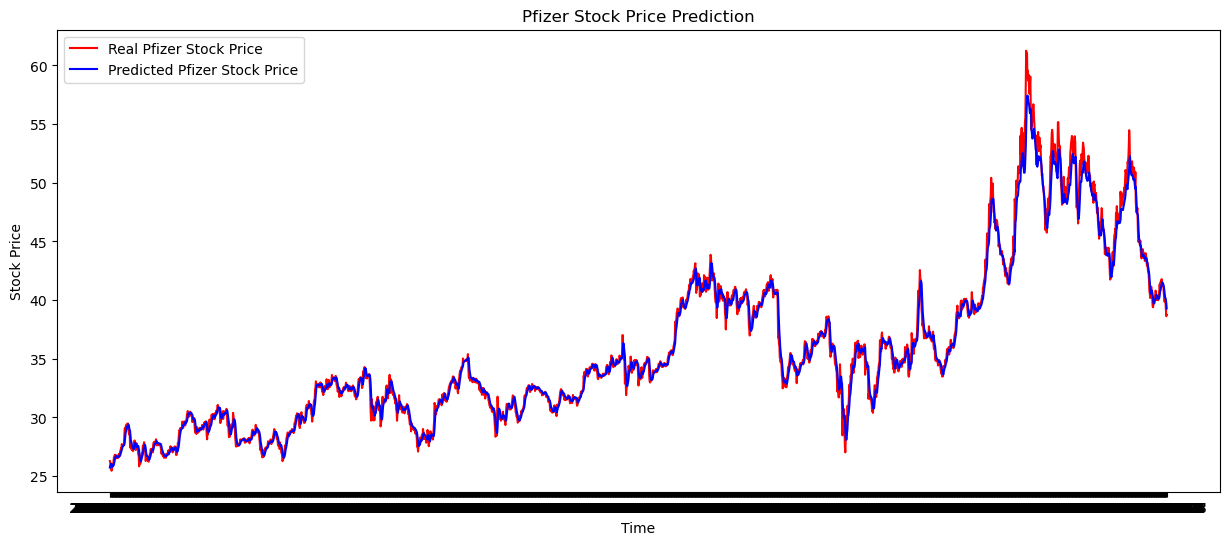

In [15]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(update_df[len(update_df)-len(y_test):].index, y_test, color = 'red', label = 'Real Pfizer Stock Price')
axes.plot(update_df[len(update_df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Pfizer Stock Price')
plt.title('Pfizer Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('stock_pred.png')
plt.show()